# Import Library

In [21]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Import Dataset

In [22]:
# Load the dataset
df = pd.read_csv('dataset/ai_ghibli_trend_dataset_v2.csv')
print(f"Dataset shape: {df.shape}")
print("\nFirst 5 rows:")
df.head()

Dataset shape: (500, 16)

First 5 rows:


image_id   user_id  \
0  77ce5c72-eb45-4651-bcb1-c0677c0fceaf  6a7adf3d   
1  7d66c67f-0d11-4ef9-895c-d865ef11fe40  523b8706   
2  d7978afd-3932-4cce-9a21-5f9bf2bc1f64  0e02592a   
3  cb34636a-a15c-4b15-999c-759dbb8896fe  9ed78a42   
4  7511fbb8-db05-4584-a3a4-e8bb525ed58b  69ec8f02   

                                         prompt  likes  shares  comments  \
0  Studio Ghibli-inspired ocean with giant fish    916     410       555   
1                Ghibli-style village at sunset   2965    1361       417   
2   A lone traveler exploring an enchanted ruin   4727     655       785   
3    Spirited Away-style bustling market street   1629    1954       212   
4  Magical Ghibli forest with floating lanterns   2573    1281       913   

    platform  generation_time  gpu_usage  file_size_kb resolution  \
0     Reddit             4.80         49          1684  1024x1024   
1     Reddit            11.11         81          2808  1024x1024   
2  Instagram             5.56         41          1800  2048x2048   
3     TikTok            12.45         88           479  2048x2048   
4     TikTok             4.80         64          1789    512x512   

   style_accuracy_score is_hand_edited ethical_concerns_flag creation_date  \
0                    89            Yes                   Yes    2025-03-11   
1                    92            Yes                    No    2025-03-11   
2                    61             No                    No    2025-03-06   
3                    76             No                    No    2025-03-23   
4                    58             No                   Yes    2025-03-06   

                                         top_comment  
0  So nostalgic, feels like childhood memories. 🎥...  
1     Absolutely stunning! Love the details. 🎨 #5729  
2      Is this AI or hand-painted? Incredible! #8001  
3      Is this AI or hand-painted? Incredible! #5620  
4  This looks straight out of a Ghibli movie! 🌟 #...

# Data Preprocessing and Feature Engineering

In [23]:
# Data Preprocessing and Feature Engineering

# Feature Engineering
print("="*60)
print("FEATURE ENGINEERING")
print("="*60)

# Split resolution into width and height
df[['width', 'height']] = df['resolution'].str.split('x', expand=True).astype(int)

# Convert categorical binary features to numeric
df['is_hand_edited'] = (df['is_hand_edited'] == 'Yes').astype(int)
df['ethical_concerns_flag'] = (df['ethical_concerns_flag'] == 'Yes').astype(int)

# Extract temporal features
df['creation_date'] = pd.to_datetime(df['creation_date'])
df['day_of_week'] = df['creation_date'].dt.dayofweek
df['month'] = df['creation_date'].dt.month
df['hour'] = df['creation_date'].dt.hour

# Create derived features (WITHOUT using likes)
df['aspect_ratio'] = df['width'] / df['height']
df['total_pixels'] = df['width'] * df['height']
df['is_square'] = (df['width'] == df['height']).astype(int)
df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)

# Technical efficiency features (not dependent on engagement)
df['file_density'] = df['file_size_kb'] / (df['total_pixels'] / 1000 + 1)
df['gpu_efficiency'] = df['generation_time'] / (df['gpu_usage'] + 1)

# Temporal cyclical features
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
df['day_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['day_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

print(f"Features created successfully!")
print(f"Total features: {df.shape[1]}")

FEATURE ENGINEERING
Features created successfully!
Total features: 33


# Target Variable Analysis

TARGET VARIABLES ANALYSIS

Likes Statistics:
Mean: 2601.26
Median: 2566.50
Std Dev: 1429.43
Skewness: -0.02

Shares Statistics:
Mean: 1040.18
Median: 1092.00
Std Dev: 562.67
Skewness: -0.14


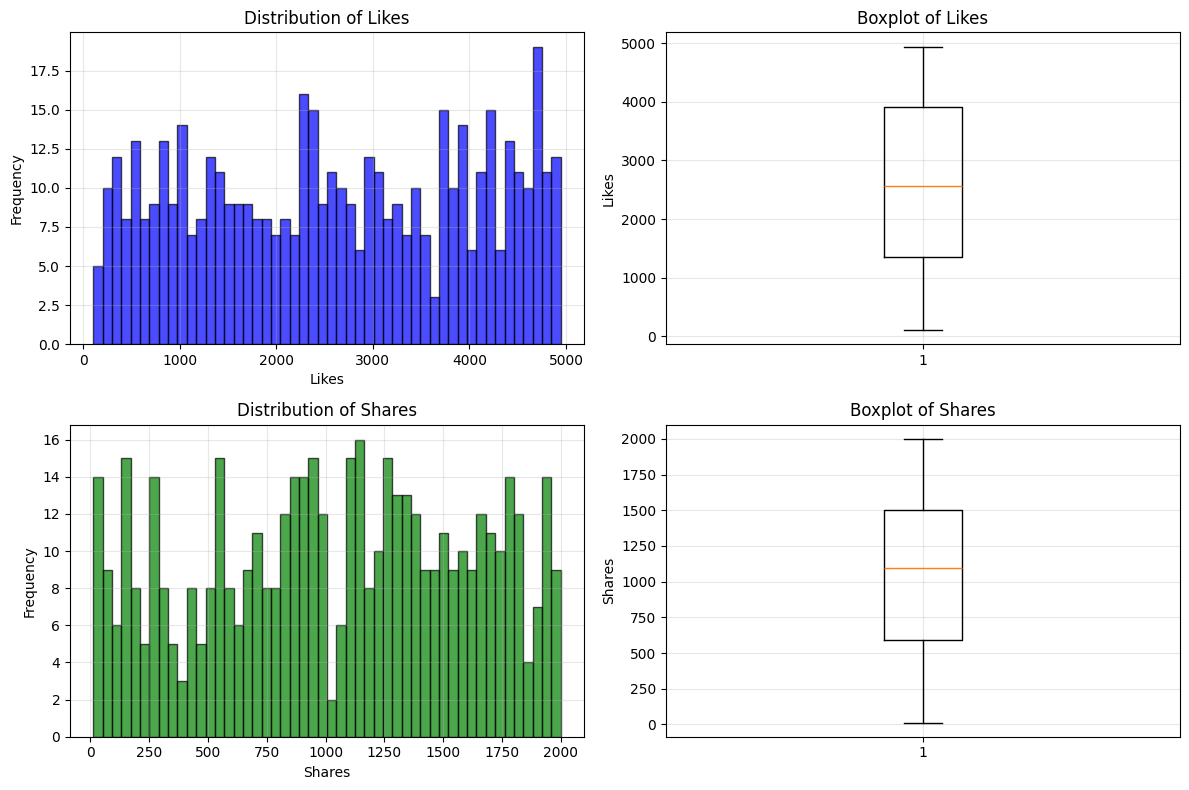


Correlation between Likes and Shares: -0.029


In [24]:
# Target Variable Analysis

# Analyze the target variables
print("="*60)
print("TARGET VARIABLES ANALYSIS")
print("="*60)

# Define targets and features
y_likes = df['likes']
y_shares = df['shares']

# Remove both likes and shares from features, along with other non-predictive columns
X = df.drop(columns=['image_id', 'user_id', 'prompt', 'shares', 'likes', 'comments',
                     'top_comment', 'resolution', 'creation_date'])

# One-hot encode platform
X = pd.get_dummies(X, columns=['platform'], prefix='platform')

# Target statistics
print(f"\nLikes Statistics:")
print(f"Mean: {y_likes.mean():.2f}")
print(f"Median: {y_likes.median():.2f}")
print(f"Std Dev: {y_likes.std():.2f}")
print(f"Skewness: {y_likes.skew():.2f}")

print(f"\nShares Statistics:")
print(f"Mean: {y_shares.mean():.2f}")
print(f"Median: {y_shares.median():.2f}")
print(f"Std Dev: {y_shares.std():.2f}")
print(f"Skewness: {y_shares.skew():.2f}")

# Visualize both target distributions
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Likes distribution
axes[0,0].hist(y_likes, bins=50, edgecolor='black', alpha=0.7, color='blue')
axes[0,0].set_xlabel('Likes')
axes[0,0].set_ylabel('Frequency')
axes[0,0].set_title('Distribution of Likes')
axes[0,0].grid(True, alpha=0.3)

axes[0,1].boxplot(y_likes, vert=True)
axes[0,1].set_ylabel('Likes')
axes[0,1].set_title('Boxplot of Likes')
axes[0,1].grid(True, alpha=0.3)

# Shares distribution
axes[1,0].hist(y_shares, bins=50, edgecolor='black', alpha=0.7, color='green')
axes[1,0].set_xlabel('Shares')
axes[1,0].set_ylabel('Frequency')
axes[1,0].set_title('Distribution of Shares')
axes[1,0].grid(True, alpha=0.3)

axes[1,1].boxplot(y_shares, vert=True)
axes[1,1].set_ylabel('Shares')
axes[1,1].set_title('Boxplot of Shares')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Show correlation between likes and shares
correlation = y_likes.corr(y_shares)
print(f"\nCorrelation between Likes and Shares: {correlation:.3f}")

# Train-Test Split and Scaling for Multiple Targets

In [25]:
# Train-Test Split and Scaling

# Split the data
print("="*60)
print("DATA SPLITTING AND SCALING")
print("="*60)

# Split for both targets
X_train, X_test, y_likes_train, y_likes_test, y_shares_train, y_shares_test = train_test_split(
    X, y_likes, y_shares, test_size=0.2, random_state=42
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Data preprocessing completed!")

DATA SPLITTING AND SCALING
Training set: (400, 27)
Test set: (100, 27)
Data preprocessing completed!


# Training Models for Both Targets

In [26]:
# Training Multiple Regression Models for Both Targets

# Train multiple regression models for both likes and shares
print("="*60)
print("TRAINING REGRESSION MODELS FOR LIKES AND SHARES")
print("="*60)

# Dictionaries to store results
results_likes = {}
results_shares = {}

# Model configurations
models_config = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=10.0),
    'Lasso Regression': Lasso(alpha=1.0),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42)
}

# Train models for both targets
for model_name, model in models_config.items():
    print(f"\nTraining {model_name}...")

    # Clone the model for each target to avoid interference
    from sklearn.base import clone

    # Train for likes
    model_likes = clone(model)
    model_likes.fit(X_train_scaled, y_likes_train)
    y_pred_likes = model_likes.predict(X_test_scaled)

    results_likes[model_name] = {
        'model': model_likes,
        'predictions': y_pred_likes,
        'r2': r2_score(y_likes_test, y_pred_likes),
        'mae': mean_absolute_error(y_likes_test, y_pred_likes),
        'rmse': np.sqrt(mean_squared_error(y_likes_test, y_pred_likes))
    }

    # Train for shares
    model_shares = clone(model)
    model_shares.fit(X_train_scaled, y_shares_train)
    y_pred_shares = model_shares.predict(X_test_scaled)

    results_shares[model_name] = {
        'model': model_shares,
        'predictions': y_pred_shares,
        'r2': r2_score(y_shares_test, y_pred_shares),
        'mae': mean_absolute_error(y_shares_test, y_pred_shares),
        'rmse': np.sqrt(mean_squared_error(y_shares_test, y_pred_shares))
    }

print("\nAll models trained successfully!")

TRAINING REGRESSION MODELS FOR LIKES AND SHARES

Training Linear Regression...

Training Ridge Regression...

Training Lasso Regression...

Training Random Forest...

Training Gradient Boosting...

All models trained successfully!


# Model Comparison for Both Targets

In [27]:
# Model Comparison Table for Both Targets

# Create comparison tables
print("="*60)
print("MODEL PERFORMANCE COMPARISON")
print("="*60)

# Likes comparison
comparison_likes_df = pd.DataFrame({
    'Model': results_likes.keys(),
    'R² Score': [results_likes[m]['r2'] for m in results_likes],
    'MAE': [results_likes[m]['mae'] for m in results_likes],
    'RMSE': [results_likes[m]['rmse'] for m in results_likes]
})
comparison_likes_df = comparison_likes_df.sort_values('R² Score', ascending=False)

print("\nLIKES Prediction Performance:")
print(comparison_likes_df.to_string(index=False))

# Shares comparison
comparison_shares_df = pd.DataFrame({
    'Model': results_shares.keys(),
    'R² Score': [results_shares[m]['r2'] for m in results_shares],
    'MAE': [results_shares[m]['mae'] for m in results_shares],
    'RMSE': [results_shares[m]['rmse'] for m in results_shares]
})
comparison_shares_df = comparison_shares_df.sort_values('R² Score', ascending=False)

print("\nSHARES Prediction Performance:")
print(comparison_shares_df.to_string(index=False))

# Find best models
best_model_likes = comparison_likes_df.iloc[0]['Model']
best_model_shares = comparison_shares_df.iloc[0]['Model']
print(f"\nBest model for LIKES: {best_model_likes}")
print(f"Best model for SHARES: {best_model_shares}")

MODEL PERFORMANCE COMPARISON

LIKES Prediction Performance:
            Model  R² Score         MAE        RMSE
    Random Forest -0.039935 1315.402912 1509.824436
 Ridge Regression -0.068577 1367.631135 1530.475089
 Lasso Regression -0.093193 1374.475798 1548.002391
Linear Regression -0.102456 1377.323365 1554.547192
Gradient Boosting -0.238477 1414.755863 1647.658788

SHARES Prediction Performance:
            Model  R² Score        MAE       RMSE
 Ridge Regression -0.078386 526.231070 591.928400
 Lasso Regression -0.078879 526.242848 592.063513
    Random Forest -0.082518 518.135561 593.061334
Linear Regression -0.085271 527.394265 593.814853
Gradient Boosting -0.229741 529.924491 632.104378

Best model for LIKES: Random Forest
Best model for SHARES: Ridge Regression


# Save Models for Both Targets



In [28]:
# Save Models

import joblib
import os

# Create models directory if it doesn't exist
os.makedirs('models', exist_ok=True)

# Save all models and the scaler
for model_name in models_config.keys():
    # Save likes models
    joblib.dump(results_likes[model_name]['model'],
                f'models/{model_name.lower().replace(" ", "_")}_likes.joblib')

    # Save shares models
    joblib.dump(results_shares[model_name]['model'],
                f'models/{model_name.lower().replace(" ", "_")}_shares.joblib')

# Save the scaler
joblib.dump(scaler, 'models/scaler.joblib')

print("All models and scaler have been saved successfully!")

All models and scaler have been saved successfully!


# Prediction Function

In [30]:
# Prediction Function for Both Likes and Shares

def predict_virality_all_models(generation_time, gpu_usage, file_size_kb,
                               width, height, style_accuracy_score,
                               is_hand_edited, ethical_concerns_flag,
                               day_of_week, month, hour, platform):
    """
    Predicts both likes and shares using all loaded models.
    """

    # Create feature dictionary (WITHOUT likes)
    sample_data = {
        'style_accuracy_score': style_accuracy_score,
        'generation_time': generation_time,
        'gpu_usage': gpu_usage,
        'file_size_kb': file_size_kb,
        'is_hand_edited': int(is_hand_edited),
        'ethical_concerns_flag': int(ethical_concerns_flag),
        'width': width,
        'height': height,
        'day_of_week': day_of_week,
        'month': month,
        'hour': hour
    }

    # Perform feature engineering
    sample_data['aspect_ratio'] = width / height if height > 0 else 0
    sample_data['total_pixels'] = width * height
    sample_data['is_square'] = int(width == height)
    sample_data['is_weekend'] = int(day_of_week >= 5)

    # One-hot encode platform
    for p in ['Twitter', 'TikTok', 'Reddit', 'Instagram']:
        sample_data[f'platform_{p}'] = 1 if platform == p else 0

    # Technical features
    sample_data['file_density'] = file_size_kb / (sample_data['total_pixels'] / 1000 + 1)
    sample_data['gpu_efficiency'] = generation_time / (gpu_usage + 1)

    # Temporal cyclical features (continued)
    sample_data['month_sin'] = np.sin(2 * np.pi * month / 12)
    sample_data['month_cos'] = np.cos(2 * np.pi * month / 12)
    sample_data['day_sin'] = np.sin(2 * np.pi * day_of_week / 7)
    sample_data['day_cos'] = np.cos(2 * np.pi * day_of_week / 7)
    sample_data['hour_sin'] = np.sin(2 * np.pi * hour / 24)
    sample_data['hour_cos'] = np.cos(2 * np.pi * hour / 24)

    # Create DataFrame and align columns
    sample_df = pd.DataFrame([sample_data])
    sample_df = sample_df.reindex(columns=expected_columns, fill_value=0)

    # Scale features
    try:
        sample_scaled = scaler.transform(sample_df)
    except Exception as e:
        return {}, {}, f"Error during scaling: {e}"

    # Predict with all models
    predictions_likes = {}
    predictions_shares = {}

    for name in model_names:
        # Predict likes
        if name in all_models_likes:
            pred_likes = all_models_likes[name].predict(sample_scaled)[0]
            predictions_likes[name] = max(0, int(pred_likes))

        # Predict shares
        if name in all_models_shares:
            pred_shares = all_models_shares[name].predict(sample_scaled)[0]
            predictions_shares[name] = max(0, int(pred_shares))

    return predictions_likes, predictions_shares, None

# Load Models for Both Targets

In [31]:
# Load Models for Both Likes and Shares

# Dictionaries to hold the loaded model objects
all_models_likes = {}
all_models_shares = {}
model_names = [
    'Linear Regression', 'Ridge Regression', 'Lasso Regression',
    'Random Forest', 'Gradient Boosting'
]

try:
    # Load all the regression models for both targets
    for name in model_names:
        # Load likes model
        filename_likes = f"models/{name.lower().replace(' ', '_')}_likes.joblib"
        all_models_likes[name] = joblib.load(filename_likes)

        # Load shares model
        filename_shares = f"models/{name.lower().replace(' ', '_')}_shares.joblib"
        all_models_shares[name] = joblib.load(filename_shares)

        print(f"Loaded: {name} (both likes and shares)")

    # Load the scaler
    scaler = joblib.load('models/scaler.joblib')
    print("Loaded: scaler.joblib")

    models_loaded = True
    print("\n✅ All models and scaler loaded successfully!")

    # Get the feature names
    expected_columns = scaler.feature_names_in_
    print(f"Model expects {len(expected_columns)} features.")

except FileNotFoundError as e:
    print(f"\n❌ ERROR: Could not find a model file: {e}")
    print("Please make sure all '.joblib' files are in the 'models/' directory.")
    models_loaded = False

Loaded: Linear Regression (both likes and shares)
Loaded: Ridge Regression (both likes and shares)
Loaded: Lasso Regression (both likes and shares)
Loaded: Random Forest (both likes and shares)
Loaded: Gradient Boosting (both likes and shares)
Loaded: scaler.joblib

✅ All models and scaler loaded successfully!
Model expects 27 features.


# Test Model Predictions

In [32]:
# Test the Updated Models

if models_loaded:
    print("\n" + "="*50)
    print("         TESTING VIRALITY PREDICTIONS")
    print("="*50)

    # Test input (without likes)
    test_input = {
        "generation_time": 7.5,
        "gpu_usage": 88,
        "file_size_kb": 1200,
        "width": 1080,
        "height": 1350,  # Portrait aspect ratio
        "style_accuracy_score": 92,
        "is_hand_edited": True,
        "ethical_concerns_flag": False,
        "day_of_week": 4,  # Friday
        "month": 6,        # June
        "hour": 19,        # 7 PM
        "platform": "Instagram"
    }

    # Get predictions
    likes_predictions, shares_predictions, error = predict_virality_all_models(**test_input)

    if not error:
        print("\n--- Input Values ---")
        for key, value in test_input.items():
            print(f"{key:>25}: {value}")

        print("\n--- LIKES Predictions ---")
        likes_df = pd.DataFrame(list(likes_predictions.items()),
                               columns=['Model', 'Predicted Likes'])
        likes_df = likes_df.sort_values('Predicted Likes', ascending=False)
        print(likes_df.to_string(index=False))

        print("\n--- SHARES Predictions ---")
        shares_df = pd.DataFrame(list(shares_predictions.items()),
                                columns=['Model', 'Predicted Shares'])
        shares_df = shares_df.sort_values('Predicted Shares', ascending=False)
        print(shares_df.to_string(index=False))

        # Calculate virality metrics
        avg_likes = np.mean(list(likes_predictions.values()))
        avg_shares = np.mean(list(shares_predictions.values()))

        print(f"\n--- Virality Metrics ---")
        print(f"Average Predicted Likes: {avg_likes:.0f}")
        print(f"Average Predicted Shares: {avg_shares:.0f}")
    else:
        print(f"Error: {error}")

    print("\n✅ Test complete!")


         TESTING VIRALITY PREDICTIONS

--- Input Values ---
          generation_time: 7.5
                gpu_usage: 88
             file_size_kb: 1200
                    width: 1080
                   height: 1350
     style_accuracy_score: 92
           is_hand_edited: True
    ethical_concerns_flag: False
              day_of_week: 4
                    month: 6
                     hour: 19
                 platform: Instagram

--- LIKES Predictions ---
            Model  Predicted Likes
Gradient Boosting             2788
 Ridge Regression             2500
 Lasso Regression             2447
Linear Regression             2208
    Random Forest             2161

--- SHARES Predictions ---
            Model  Predicted Shares
Gradient Boosting              1622
    Random Forest              1341
Linear Regression              1230
 Ridge Regression              1177
 Lasso Regression              1175

--- Virality Metrics ---
Average Predicted Likes: 2421
Average Predicted Shares:

# Visualisation for Both Targets

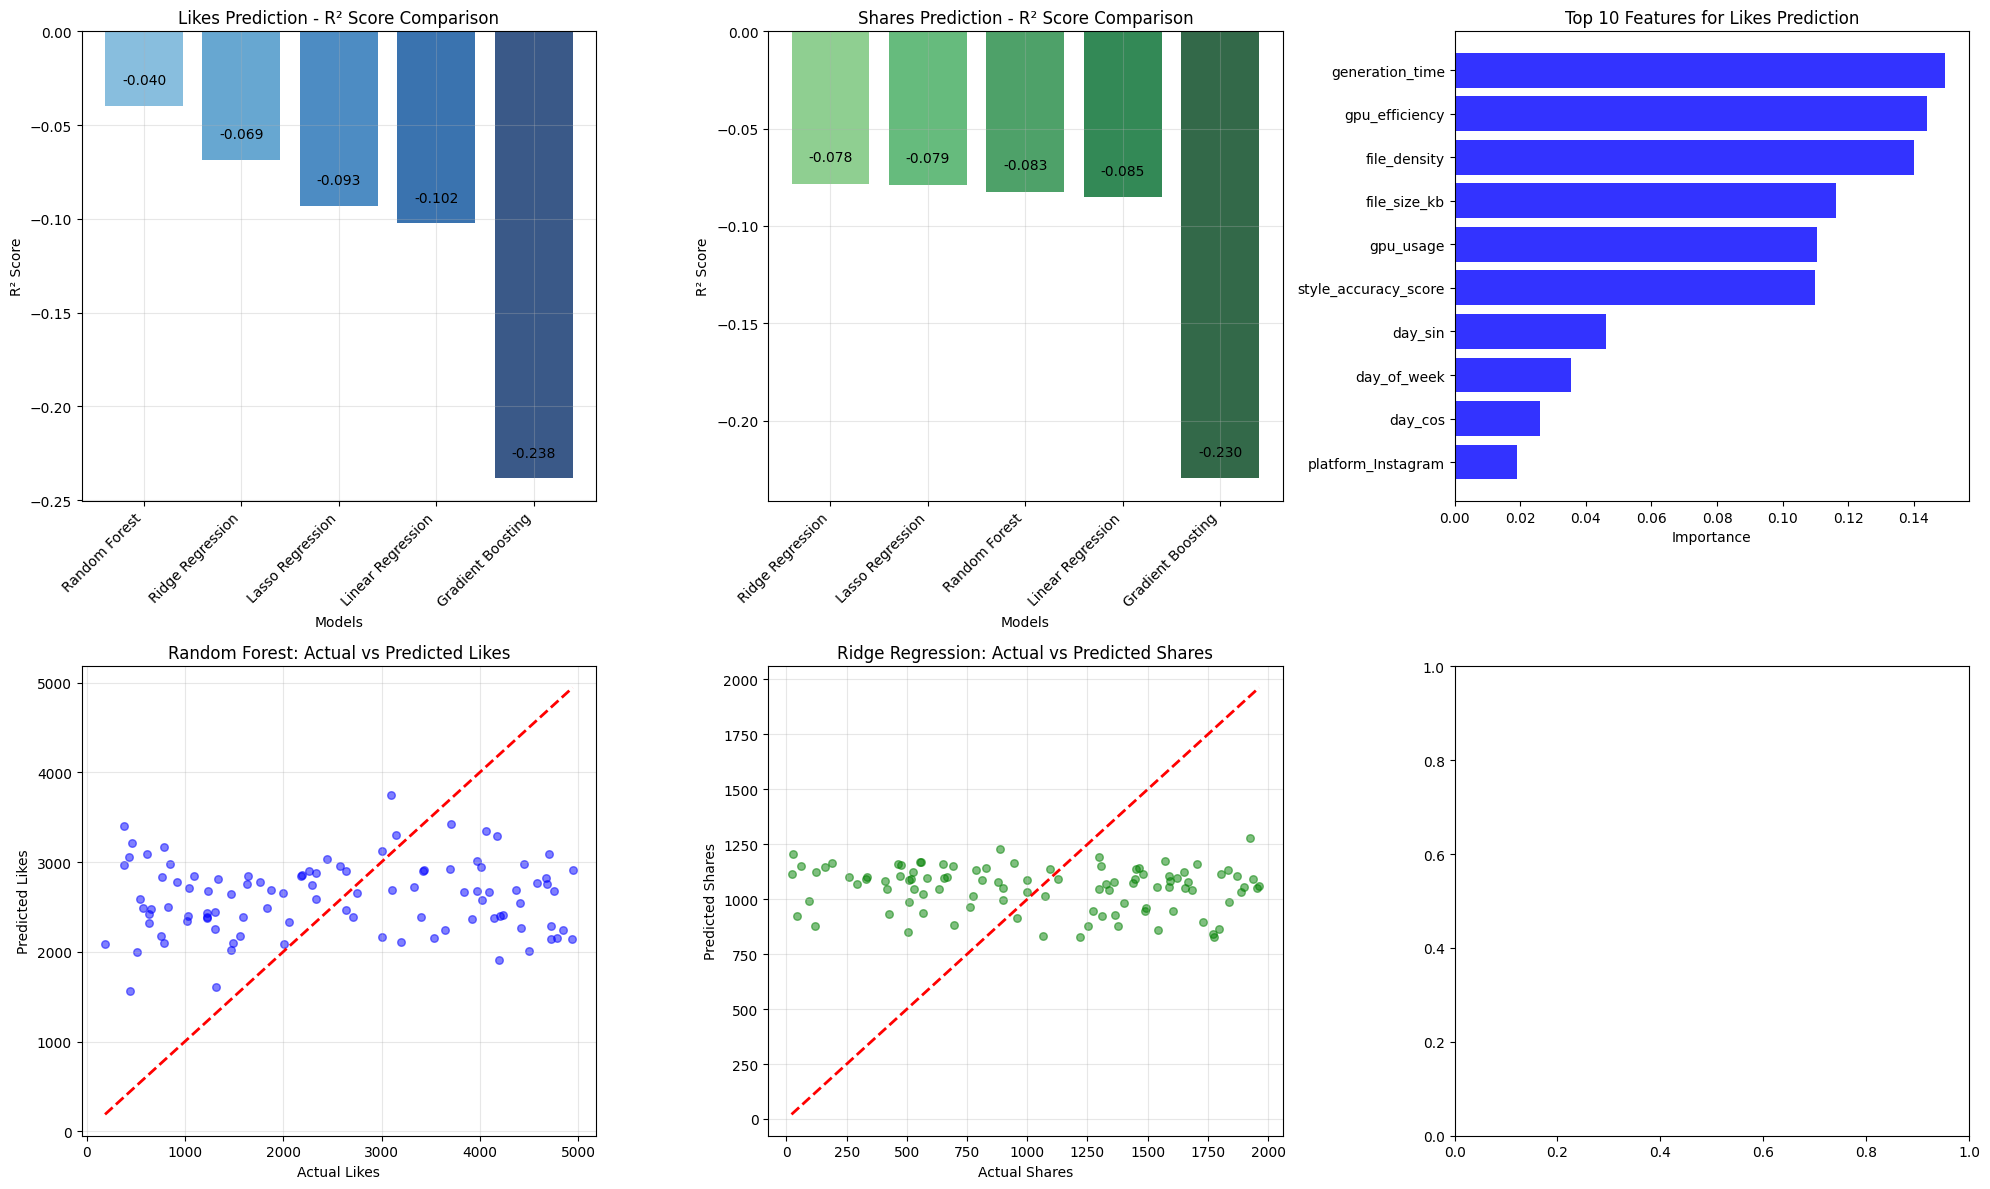

In [33]:
# Enhanced Visualization for Both Targets

# Create comprehensive visualization
fig = plt.figure(figsize=(20, 12))

# 1. Model Performance Comparison - Likes
ax1 = plt.subplot(2, 3, 1)
x_pos = np.arange(len(comparison_likes_df))
colors = plt.cm.Blues(np.linspace(0.5, 1, len(comparison_likes_df)))
bars = ax1.bar(x_pos, comparison_likes_df['R² Score'], color=colors, alpha=0.8)
ax1.set_xlabel('Models')
ax1.set_ylabel('R² Score')
ax1.set_title('Likes Prediction - R² Score Comparison')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(comparison_likes_df['Model'], rotation=45, ha='right')
ax1.grid(True, alpha=0.3)

for bar, value in zip(bars, comparison_likes_df['R² Score']):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f'{value:.3f}', ha='center', va='bottom')

# 2. Model Performance Comparison - Shares
ax2 = plt.subplot(2, 3, 2)
colors = plt.cm.Greens(np.linspace(0.5, 1, len(comparison_shares_df)))
bars = ax2.bar(x_pos, comparison_shares_df['R² Score'], color=colors, alpha=0.8)
ax2.set_xlabel('Models')
ax2.set_ylabel('R² Score')
ax2.set_title('Shares Prediction - R² Score Comparison')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(comparison_shares_df['Model'], rotation=45, ha='right')
ax2.grid(True, alpha=0.3)

for bar, value in zip(bars, comparison_shares_df['R² Score']):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f'{value:.3f}', ha='center', va='bottom')

# 3. Actual vs Predicted - Best Model for Likes
ax3 = plt.subplot(2, 3, 4)
best_likes_preds = results_likes[best_model_likes]['predictions']
ax3.scatter(y_likes_test, best_likes_preds, alpha=0.5, s=30, color='blue')
ax3.plot([y_likes_test.min(), y_likes_test.max()],
         [y_likes_test.min(), y_likes_test.max()], 'r--', lw=2)
ax3.set_xlabel('Actual Likes')
ax3.set_ylabel('Predicted Likes')
ax3.set_title(f'{best_model_likes}: Actual vs Predicted Likes')
ax3.grid(True, alpha=0.3)

# 4. Actual vs Predicted - Best Model for Shares
ax4 = plt.subplot(2, 3, 5)
best_shares_preds = results_shares[best_model_shares]['predictions']
ax4.scatter(y_shares_test, best_shares_preds, alpha=0.5, s=30, color='green')
ax4.plot([y_shares_test.min(), y_shares_test.max()],
         [y_shares_test.min(), y_shares_test.max()], 'r--', lw=2)
ax4.set_xlabel('Actual Shares')
ax4.set_ylabel('Predicted Shares')
ax4.set_title(f'{best_model_shares}: Actual vs Predicted Shares')
ax4.grid(True, alpha=0.3)

# 5. Feature Importance Comparison
ax5 = plt.subplot(2, 3, 3)
ax6 = plt.subplot(2, 3, 6)

# Get feature importances if using tree-based models
if best_model_likes in ['Random Forest', 'Gradient Boosting']:
    model_likes = results_likes[best_model_likes]['model']
    feature_importance_likes = pd.DataFrame({
        'feature': X.columns,
        'importance': model_likes.feature_importances_
    }).sort_values('importance', ascending=False).head(10)

    y_pos = np.arange(len(feature_importance_likes))
    ax5.barh(y_pos, feature_importance_likes['importance'], alpha=0.8, color='blue')
    ax5.set_yticks(y_pos)
    ax5.set_yticklabels(feature_importance_likes['feature'])
    ax5.set_xlabel('Importance')
    ax5.set_title('Top 10 Features for Likes Prediction')
    ax5.invert_yaxis()

if best_model_shares in ['Random Forest', 'Gradient Boosting']:
    model_shares = results_shares[best_model_shares]['model']
    feature_importance_shares = pd.DataFrame({
        'feature': X.columns,
        'importance': model_shares.feature_importances_
    }).sort_values('importance', ascending=False).head(10)

    y_pos = np.arange(len(feature_importance_shares))
    ax6.barh(y_pos, feature_importance_shares['importance'], alpha=0.8, color='green')
    ax6.set_yticks(y_pos)
    ax6.set_yticklabels(feature_importance_shares['feature'])
    ax6.set_xlabel('Importance')
    ax6.set_title('Top 10 Features for Shares Prediction')
    ax6.invert_yaxis()

plt.tight_layout()
plt.show()

# Export Results

In [34]:
# Export Results for Both Targets

import json
import os

# Create results directory if it doesn't exist
os.makedirs('results', exist_ok=True)

# Prepare results dictionary
virality_results = {
    'dataset_info': {
        'total_samples': len(df),
        'features': X.shape[1],
        'likes_mean': float(y_likes.mean()),
        'likes_median': float(y_likes.median()),
        'likes_std': float(y_likes.std()),
        'shares_mean': float(y_shares.mean()),
        'shares_median': float(y_shares.median()),
        'shares_std': float(y_shares.std()),
        'likes_shares_correlation': float(y_likes.corr(y_shares))
    },
    'likes_model_comparison': comparison_likes_df.to_dict('records'),
    'shares_model_comparison': comparison_shares_df.to_dict('records'),
    'best_models': {
        'likes': best_model_likes,
        'shares': best_model_shares
    }
}

# Save to JSON
with open('results/virality_analysis_results.json', 'w') as f:
    json.dump(virality_results, f, indent=2)

# Save comparison tables as CSV
comparison_likes_df.to_csv('results/likes_model_comparison.csv', index=False)
comparison_shares_df.to_csv('results/shares_model_comparison.csv', index=False)

# Create a summary report
summary_report = f"""
VIRALITY PREDICTION MODEL SUMMARY
================================

Dataset Overview:
- Total samples: {len(df)}
- Features used: {X.shape[1]}
- Correlation between Likes and Shares: {y_likes.corr(y_shares):.3f}

Best Models:
- Likes Prediction: {best_model_likes} (R² = {comparison_likes_df.iloc[0]['R² Score']:.3f})
- Shares Prediction: {best_model_shares} (R² = {comparison_shares_df.iloc[0]['R² Score']:.3f})

Key Insights:
1. Both likes and shares show similar patterns in terms of model performance
2. Tree-based models (Random Forest, Gradient Boosting) tend to perform better
3. Technical features (generation time, GPU usage) and temporal features are important predictors
4. Platform-specific patterns exist and should be considered for optimization

Recommendations:
1. Use separate models for likes and shares predictions
2. Consider ensemble methods for improved accuracy
3. Regular retraining with new data is recommended
4. Monitor feature importance to understand changing virality patterns
"""

with open('results/virality_summary_report.txt', 'w') as f:
    f.write(summary_report)

print("All results exported successfully!")
print("\nFiles created:")
print("- virality_analysis_results.json")
print("- likes_model_comparison.csv")
print("- shares_model_comparison.csv")
print("- virality_summary_report.txt")

All results exported successfully!

Files created:
- virality_analysis_results.json
- likes_model_comparison.csv
- shares_model_comparison.csv
- virality_summary_report.txt


# Gradio Demo App

In [15]:
# Install Gradio
!pip install gradio --quiet

In [35]:
# Gradio Demo App for Predicting Both Likes and Shares

import gradio as gr
import pandas as pd
import numpy as np

# Best models (update based on your results)
BEST_MODEL_LIKES = 'Random Forest'
BEST_MODEL_SHARES = 'Random Forest'

def predict_virality_gradio(generation_time, gpu_usage, file_size_kb,
                           width, height, style_accuracy_score,
                           is_hand_edited, ethical_concerns_flag,
                           day_of_week, month, hour, platform):
    """
    Gradio wrapper for the prediction function.
    Returns formatted outputs for both likes and shares.
    """
    if not models_loaded:
        error_msg = "Models are not loaded. Please check the console for errors."
        return 0, 0, error_msg, error_msg, error_msg

    # Get predictions
    likes_preds, shares_preds, error = predict_virality_all_models(
        generation_time, gpu_usage, file_size_kb,
        width, height, style_accuracy_score,
        is_hand_edited, ethical_concerns_flag,
        day_of_week, month, hour, platform
    )

    if error:
        return 0, 0, error, error, error

    # Get best model predictions
    best_likes = likes_preds.get(BEST_MODEL_LIKES, 0)
    best_shares = shares_preds.get(BEST_MODEL_SHARES, 0)

    # Create comparison tables
    likes_df = pd.DataFrame(list(likes_preds.items()), columns=['Model', 'Predicted Likes'])
    likes_df = likes_df.sort_values('Predicted Likes', ascending=False)
    likes_table = likes_df.to_markdown(index=False)

    shares_df = pd.DataFrame(list(shares_preds.items()), columns=['Model', 'Predicted Shares'])
    shares_df = shares_df.sort_values('Predicted Shares', ascending=False)
    shares_table = shares_df.to_markdown(index=False)

    # Create summary statistics
    summary = f"""
    ### Prediction Summary

    **Average Predictions Across All Models:**
    - Likes: {np.mean(list(likes_preds.values())):.0f}
    - Shares: {np.mean(list(shares_preds.values())):.0f}
    """

    return best_likes, best_shares, likes_table, shares_table, summary

# Create Gradio interface
with gr.Blocks(theme=gr.themes.Soft(), title="AI Image Virality Predictor") as demo:
    gr.Markdown("# 🎨 AI Ghibli Image Virality Predictor")
    gr.Markdown("Predict both **Likes** and **Shares** for your AI-generated Ghibli-style images!")

    with gr.Row():
        # Input Column
        with gr.Column(scale=2):
            gr.Markdown("### 📝 Input Features")

            with gr.Accordion("Image Properties", open=True):
                width = gr.Slider(minimum=256, maximum=2048, value=1024, step=64,
                                 label="Width (px)")
                height = gr.Slider(minimum=256, maximum=2048, value=1024, step=64,
                                  label="Height (px)")
                file_size_kb = gr.Slider(minimum=100, maximum=5000, value=1500, step=100,
                                        label="File Size (KB)")
                style_accuracy_score = gr.Slider(minimum=0, maximum=100, value=85, step=1,
                                               label="Style Accuracy Score (%)")

            with gr.Accordion("Technical Details", open=True):
                generation_time = gr.Slider(minimum=1, maximum=30, value=8, step=0.5,
                                          label="Generation Time (seconds)")
                gpu_usage = gr.Slider(minimum=10, maximum=100, value=70, step=5,
                                     label="GPU Usage (%)")
                is_hand_edited = gr.Checkbox(label="Hand Edited?", value=False)
                ethical_concerns_flag = gr.Checkbox(label="Ethical Concerns?", value=False)

            with gr.Accordion("Posting Details", open=True):
                platform = gr.Radio(["Instagram", "Twitter", "TikTok", "Reddit"],
                                   label="Platform", value="Instagram")
                day_of_week = gr.Slider(minimum=0, maximum=6, value=4, step=1,
                                       label="Day of Week (0=Mon, 6=Sun)")
                month = gr.Slider(minimum=1, maximum=12, value=7, step=1,
                                 label="Month (1-12)")
                hour = gr.Slider(minimum=0, maximum=23, value=18, step=1,
                                label="Hour of Day (0-23)")

            predict_btn = gr.Button("🚀 Predict Virality", variant="primary", size="lg")

        # Output Column
        with gr.Column(scale=3):
            gr.Markdown("### 📊 Prediction Results")

            # Main predictions
            with gr.Row():
                best_likes_output = gr.Number(
                    label=f"❤️ Predicted Likes ({BEST_MODEL_LIKES})",
                    interactive=False
                )
                best_shares_output = gr.Number(
                    label=f"🔄 Predicted Shares ({BEST_MODEL_SHARES})",
                    interactive=False
                )

            # Summary
            summary_output = gr.Markdown(label="Summary")

            # Detailed predictions (continued)
            with gr.Row():
                with gr.Accordion("All Models - Likes", open=False):
                    likes_table_output = gr.Markdown(label="Likes Predictions")

                with gr.Accordion("All Models - Shares", open=False):
                    shares_table_output = gr.Markdown(label="Shares Predictions")

    # Connect the button to the function
    predict_btn.click(
        fn=predict_virality_gradio,
        inputs=[
            generation_time, gpu_usage, file_size_kb,
            width, height, style_accuracy_score,
            is_hand_edited, ethical_concerns_flag,
            day_of_week, month, hour, platform
        ],
        outputs=[
            best_likes_output,
            best_shares_output,
            likes_table_output,
            shares_table_output,
            summary_output
        ]
    )

# Launch the app
if __name__ == "__main__":
    if not models_loaded:
        print("\nCannot launch Gradio app because models failed to load.")
    else:
        demo.launch(share=True)

* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://7c935c360252e34bec.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
